<a href="https://colab.research.google.com/github/Fiiila/USVP_2022/blob/main/Semestralka_USVP_TTS_ASR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from requests.auth import HTTPDigestAuth
from IPython.display import Audio
from collections import namedtuple
import urllib.request
import pandas as pd
from numpy import random
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import librosa
from google.colab import files
import math
import sys

In [2]:
# TTS-Service credentials
USERNAME = "kky_usvp"
PASSWORD = "queN7aex"

# TTS-Service API ROOT and available Czech voices and formats
TTS_ROOT = "https://services.speechtech.cz/tts/v3/synth"
VOICES_CS = ["Jan210", "Alena210", "Iva210", "Radka210", "Stanislav210", "Jiri210"]
FORMATS = ["mp3", "wav44kHz16bit"]

In [3]:
# UWebASR API ROOT
ASR_ROOT = "https://uwebasr.zcu.cz/api/v1/"

In [4]:
def synthesize(out_fn, text, voice, fmt):
    """Synthesize the text into out_fn

    The voice of speech synthesis and the output format could be specified.

    Example:
    synthesize("test.wav", "hello world", "Jeremy210", "wav44kHz16bit")

    TTS-Server is provided by the company SpeechTech s.r.o.
    """
    r = requests.get(TTS_ROOT,
                     auth=HTTPDigestAuth(USERNAME, PASSWORD),
                     params={"text": text,
                             "engine": voice,
                             "format": fmt}
                    )
    r.raise_for_status()
    with open(out_fn, "wb") as fw:
        fw.write(r.content)

In [5]:
def recognize(fn, model, words_only=False):
    """Recognizes the file fn using the UWebASR service

    The model must be supplied to identify the recognition model.

    If words_only is True, then the function returns array of words,
    otherwise it returns array of dictionaries containing more detailed
    recognition results.

    Example: 
    recognize("test.wav", "CLARIN_ASR/CZ")

    UWebASR service is provided by Department of Cybernetics, University of
    West Bohemia
    """
    with open(fn, "rb") as fr:
        r = requests.post(ASR_ROOT+model, data=fr, params={"format": "json"})
        r.raise_for_status()
        ret = r.json()
    if words_only:
        ret = [i["word"] for i in ret]
    return ret

In [6]:
synthesize("test.wav", "Ahoj, jak se máš?", "Iva210", "wav44kHz16bit")
Audio("test.wav")

In [7]:
recognize("test.wav", "CLARIN_ASR/CZ", words_only=True)

['Ahoj', 'jak', 'se', 'máš']

In [8]:
OP_OK = 'o'
OP_SUB = 's'
OP_INS = 'i'
OP_DEL = 'd'

COST_SUB = 1
COST_INS = 1
COST_DEL = 1

def Levenshtein(vzor, test):
    """Calculates Levenshtein distance and corresponding edit operations"""
    m = len(vzor)
    n = len(test)
    vzor = [' ']+vzor
    test = [' ']+test

    last_row = [i*COST_INS for i in range(n+1)]
    last_row_op = [OP_INS*i for i in range(n+1)]

    for i in range(1, m+1):
        current = [i*COST_DEL]
        current_op = [OP_DEL*i]
        for j in range(1, n+1):
            if vzor[i] == test[j]:
                cost_sub = 0
                sub_op = OP_OK
            else:
                cost_sub = COST_SUB
                sub_op = OP_SUB
            cost_del = COST_INS
            cost_ins = COST_DEL
            min_cost, min_op = min(
                    [last_row[j]+cost_del, last_row_op[j]+OP_DEL],
                    [current[j-1]+cost_ins, current_op[j-1]+OP_INS],
                    [last_row[j-1]+cost_sub, last_row_op[j-1]+sub_op],
            )

            current.append(min_cost)
            current_op.append(min_op)
        last_row = current
        last_row_op = current_op

    return current[-1], current_op[-1]


In [9]:
edit_counts = namedtuple("edit_counts", "N S D I H")

def calc_edit_ops(ref, hyp):
    """Calculates and returns number of edit operations

    N Number of tokens in the reference
    H Number of correctly recognized tokens
    S Number of substitutions
    D Number of deletions
    I Number of insertions
    """
    dist, ops = Levenshtein(ref, hyp)
    H = I = D = S = 0
    for op in ops:
        if op == OP_SUB:
            S += 1
        elif op == OP_DEL:
            D += 1
        elif op == OP_INS:
            I += 1
        elif op == OP_OK:
            H += 1
    N = len(ref)
    return edit_counts(N=N, S=S, D=D, I=I, H=H)

In [10]:
e = calc_edit_ops(["ahoj", "jak", "se", "máš"], ["ahojky", "jak", "se"])

In [11]:
print(e)
accuracy = (e.N-e.S-e.D-e.I)/e.N
print(accuracy)

edit_counts(N=4, S=1, D=1, I=0, H=2)
0.5


In [12]:
INPUT_TEXT = """Provozovatel holešovské autoškoly Vladimír Dohnal popisuje rozhodnutí vlády o dřívějším otevření některých obchodů a provozoven za šílené a nepřipravené.
Kvůli šibeničnímu termínu tak v pondělí neotevřely některé zoologické zahrady či knihovny, byť už by mohly.
Přes víkend totiž většinou nestačily zajistit hygienická opatření nebo spustit online nákup vstupenek.
Regionální stanice Českého rozhlasu těžkosti některých provozovatelů zmapovaly.
"""

# Semestrální práce

## úkol 1
* Proveďte syntézu a rozpoznání na 10 řádkovém textu http://home.zcu.cz/~honzas/KKY_USVP.10.txt (kódování UTF-8). Použijte hlas "Alena210".
* Vyhodnoťte přesnost rozpoznávání (accuracy) - pro jednotlivé věty a celou sadu.
* Pozn.:
 * věta = řádka  (splitlines())
 * interpunkce - vliv na TTS a ASR  vs. vyhodnocení
 * doporučuji si poslechnout
 * výstup - tabulka v colab/jupyter notebooku

## úkol 2

*   Promyslete si několik způsobů zašumění akustického signálu (bílý šum, konvolutorní šum, přimíchání řeči na pozadí)
*   Pro každý ze způsobů zašumění připravte jako funkci:
```
def noise(fn, out_fn, intensity):
    "Tělo vaší funkce"
```
*   Zašumovací funkci zapojte do vašeho řetězce volání funkcí: TTS-ASR-evaluate
*   Proveďte syntézu a rozpoznání na 20 řádkovém textu http://home.zcu.cz/~honzas/KKY_USVP.20.txt (kódování UTF-8). *(můžete využít různé hlasy)*
*   Pro každou zašumovací funkci (případně hlas) vyhodnoťte celkovou přesnost rozpoznávání.
*   Způsob zašumění/hlas a odpovídající přesnost zobrazte v tabulce, případně graficky.

## úkol 3

*   Odpovězte na následující otázky:
 *   Proč i bez použití šumu je přesnost rozpoznávání menší než 100%?  
 *   Najděte 5 příkladů slov, které rozpoznávač nedokáže rozpoznat. Jak se tato chyba projeví na celkové přesnosti rozpoznávání? *(chyba rozpoznávání vs. OOV)*
 *   Při jaké chybovosti se již nedá pochopit význam výstupních hypotéz?






## Úkol 1

In [13]:
#@markdown Načtení vstupních dat do pole
req = urllib.request.urlopen("http://home.zcu.cz/~honzas/KKY_USVP.10.txt")
cont = req.read().decode('utf8')
print(f"SOURCE CONTENT\n{cont}")
cont_lines = cont.splitlines()# rozdelene na radky
print(cont_lines)

SOURCE CONTENT
O půlnoci odešla Velká Británie z Evropské unie . Stalo se tak následkem referenda , ve kterém byl výsledek v mezích statistické chyby . Následek ? Rozdělený národ , hrozba rozpadu země , posíleny odstředivé proudy , nejistá budoucnost , nejistota . 
 To jsou mnohokrát opakovaná fakta . 
 Vina je na Junckerově vedení Unie , které nebylo ochotno přistoupit na jednoduchou tezi , že členské státy Unie mají mít právo rozhodovat o tom , kdo může a nemůže fungovat na jejich území a účastnit se systému sociální podpory . To byl zásadní britský požadavek , ten byl zamítnut ve prospěch prosazování fikce o jednolitém evropském prostoru . Takže odešla pátá největší ekonomika světa . 
 Co bude dál ? 
 To nikdo neví . Půlnoční odchod neznamená nic jiného , než že výsledek toho těsného referenda platí . Je to absurdní , je to hanba , je to zavrženíhodné , ale je to tak . 
 Napříště budeme ušetřeni trapných - televizí přenášených - parlamentních tahanic . Ale nejistota zůstala , včetně

In [14]:
#@markdown Syntéza požadovaného desetiřádkoveho textu
for i in range(len(cont_lines)):
  synthesize(f"ukol_01_radek_{i:02}.wav", cont_lines[i], "Alena210", "wav")

In [15]:
#@markdown Rozpoznání jednotlivých řádků importovaného textu
rec = []
for i in range(len(cont_lines)):
  rec.append(" ".join(recognize(f"ukol_01_radek_{i:02}.wav", "CLARIN_ASR/CZ", words_only=True)))
print(f"RECOGNITION\n{rec}")

RECOGNITION
['O půlnoci odešla Velká Británie z EU stalo se tak následkem referenda ve kterém byl výsledek v mezích statistické chyby následek rozdělený národ hrozba rozpadu země posíleny odstředivé proudy nejistá budoucnost nejistota', 'To jsou mnohokrát opakovaná fakta', 'Vina je na Junckerově vedení unie které nebylo ochotno přistoupit na jednoduchou tezi že členské státy unie mají mít právo rozhodovat o tom kdo může a nemůže fungovat na jejich území a účastnit se systému sociální podpory to bylo zásadní britský požadavek ten byl zamítnut ve prospěch prosazování fikce o jednolitém evropském prostoru takže odešla pátá největší ekonomika světa', 'Co bude dále', 'To nikdo neví půlnoční odchod neznamená nic jiného než že výsledek toho těsného referenda platí je to absurdní je to hanba je to zavrženíhodné ale je to tak', 'Napříště budeme ušetřeni trapných televizí přenášených parlamentních tahanic ale nejistota zůstala včetně hrozby tvrdého Brexitu se cly a nedejbože vízy na hranicích', 

In [16]:
#@markdown #Výpočet přesnosti rozpoznání na neupravených datech
print(f"\nACCURACY")
acc_no_modd = []
N = 0
S = 0
D = 0
I = 0
for i in range(len(cont_lines)):
  e = calc_edit_ops(cont_lines[i].split(),rec[i].split())
  N+=e.N
  S+=e.S
  D+=e.D
  I+=e.I
  accuracy = (e.N-e.S-e.D-e.I)/e.N
  acc_no_modd.append(accuracy)
  print(f"radek {i:02}: {accuracy}")
print(f"cela sada: {(N-S-D-I)/N}")


ACCURACY
radek 00: 0.6666666666666666
radek 01: 0.8333333333333334
radek 02: 0.8181818181818182
radek 03: 0.5
radek 04: 0.7428571428571429
radek 05: 0.7407407407407407
radek 06: 0.8695652173913043
radek 07: 0.7142857142857143
radek 08: 0.875
radek 09: 0.7777777777777778
cela sada: 0.7677165354330708


In [17]:
#@markdown Odstranění interpunkce a nahrazení velkých písmen malými
cont_lines_modded = cont_lines.copy()
for i in range(len(cont_lines_modded)):
  cont_lines_modded[i] = cont_lines_modded[i].replace(".","").lower()
  cont_lines_modded[i] = cont_lines_modded[i].replace(",","")
  cont_lines_modded[i] = cont_lines_modded[i].replace("  "," ")
  cont_lines_modded[i] = cont_lines_modded[i].replace("?","")
print(cont_lines_modded[0])

o půlnoci odešla velká británie z evropské unie stalo se tak následkem referenda ve kterém byl výsledek v mezích statistické chyby následek  rozdělený národ hrozba rozpadu země posíleny odstředivé proudy nejistá budoucnost nejistota 


In [18]:
#@markdown #Výpočet přesnosti pro upravená data

#@markdown (odstaněná interpunkce, nahrazené znaky a zmenšwní velkých písmen)
print(f"\nACCURACY")
acc_modded = []
N = 0
S = 0
D = 0
I = 0
for i in range(len(cont_lines_modded)):
  e = calc_edit_ops(cont_lines_modded[i].split(),rec[i].lower().split())
  N+=e.N
  S+=e.S
  D+=e.D
  I+=e.I
  accuracy = (e.N-e.S-e.D-e.I)/e.N
  acc_modded.append(accuracy)
  print(f"radek {i:02}: {accuracy}")
print(f"cela sada: {(N-S-D-I)/N}")


ACCURACY
radek 00: 0.9393939393939394
radek 01: 1.0
radek 02: 0.9830508474576272
radek 03: 0.6666666666666666
radek 04: 1.0
radek 05: 0.9166666666666666
radek 06: 1.0
radek 07: 1.0
radek 08: 1.0
radek 09: 1.0
cela sada: 0.9719626168224299


In [19]:
#@title {run: "auto"}
no = 0 #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] {type:"raw"}
Audio(f"ukol_01_radek_{no:02}.wav")

In [20]:
df = pd.DataFrame()
df["sentence"] = cont_lines
df["without mod"] = acc_no_modd
df["mod"] = acc_modded
df

sentence  without mod       mod
0  O půlnoci odešla Velká Británie z Evropské uni...     0.666667  0.939394
1               To jsou mnohokrát opakovaná fakta .      0.833333  1.000000
2   Vina je na Junckerově vedení Unie , které neb...     0.818182  0.983051
3                                     Co bude dál ?      0.500000  0.666667
4   To nikdo neví . Půlnoční odchod neznamená nic...     0.742857  1.000000
5   Napříště budeme ušetřeni trapných - televizí ...     0.740741  0.916667
6   Vedení unie nepochybně selhalo a otevřelo spo...     0.869565  1.000000
7                 Nicméně , ani to není podstatné .      0.714286  1.000000
8        Je třeba se na situaci dívat realisticky .      0.875000  1.000000
9   I v této turbulentní době se ozývají hlasy pr...     0.777778  1.000000

## Úkol 2

Nahrání zvuku hovoru pro zanášení šumu do syntetizované řeči

In [21]:
# upload crowd_talking.wav
!git clone https://github.com/Fiiila/USVP_2022.git
intensities = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

Cloning into 'USVP_2022'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 228 (delta 0), reused 113 (delta 0), pack-reused 113
Receiving objects: 100% (228/228), 172.54 MiB | 32.02 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (225/225), done.


In [56]:
#@markdown noising function
def noise(fn, out_fn=0, intensity=0, sr=0):
  # bily sum
  if out_fn==0:
    noise = random.normal(loc=0,scale=0.5, size=len(fn))
    noise /=noise.max()
  # hovor na pozadi
  elif out_fn==1:
    noise, _ = librosa.load("USVP_2022/crowd_talking.wav")
    noise /= noise.max()
    noise = noise[0:len(fn)]
  if intensity==0.0:
    noise = np.zeros(len(fn))
    #print(f"\nIntensity: {intensity}\nSignal to noise ratio: -")
    snr=None
  else:
    noise = intensity*noise
    snr = 20*np.log10(((fn.dot(fn)/len(fn)))/((noise.dot(noise)/len(noise))))
    #print(f"\nIntensity: {intensity}\nSignal to noise ratio: {snr}")
  noise = fn+noise
    
  
  return noise, snr

Experimentální zašumění individuálních vět

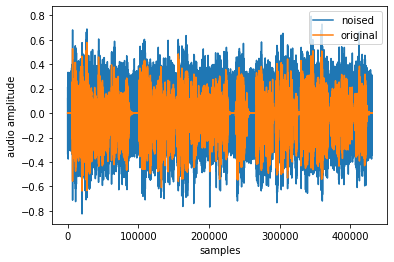

In [63]:
#@title {run:"auto"}
noise_type = 0 #@param ["0", "1"] {type:"raw"}
no_sentence = 0 #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] {type:"raw"}
intensity = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
numpy_wavfile, sample_rate = librosa.load(f"ukol_01_radek_{no_sentence:02}.wav")
#sample_rate, numpy_wavfile = wavfile.read(f"ukol_01_radek_{b:02}.wav")
noised_wavfile, _ = noise(numpy_wavfile,out_fn=noise_type, intensity=intensity, sr=sample_rate)
noised_wavfile = noised_wavfile.astype(np.float32)

wavfile.write("pokus.wav",rate=sample_rate, data=noised_wavfile)

plt.figure()
plt.plot(np.arange(len(numpy_wavfile)),noised_wavfile, label="noised")
plt.plot(np.arange(len(numpy_wavfile)),numpy_wavfile, label="original")

plt.legend(loc=1)
plt.xlabel("samples")
plt.ylabel("audio amplitude")
plt.show()
Audio(f"ukol_01_radek_{no_sentence:02}.wav")

In [24]:
#@markdown playback of noised signal
Audio("pokus.wav")

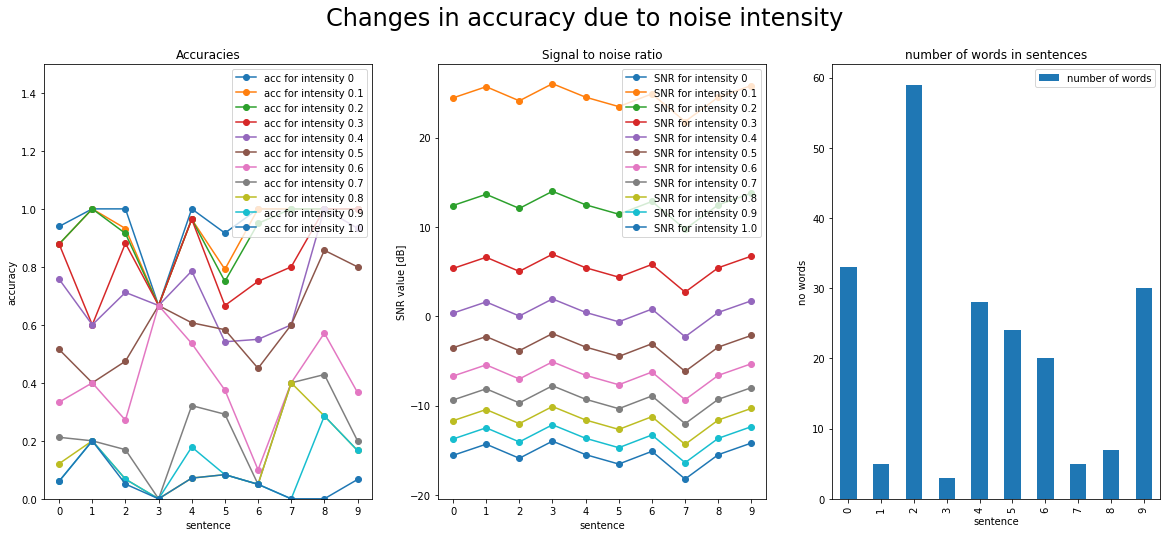

In [40]:
#@title {run:"auto"}
#@markdown #Srovnání přesností pro jednotlivé věty a intenzity zašumění
#@markdown ___
csv = "background_talk_comparison" #@param ["white_noise_comparison", "background_talk_comparison"]
compare = pd.read_csv(f"USVP_2022/{csv}.csv")
y=["acc for intensity 0", "acc for intensity 0.1", "acc for intensity 0.2", "acc for intensity 0.3", "acc for intensity 0.4", "acc for intensity 0.5", "acc for intensity 0.6", "acc for intensity 0.7", "acc for intensity 0.8", "acc for intensity 0.9", "acc for intensity 1.0"]
noOfgraphs = 11 #@param {type:"slider", min:2, max:11, step:1}
y=y[0:noOfgraphs]
style = ["-o"]*len(y)
plt.figure(figsize=(20,8))
plt.suptitle("Changes in accuracy due to noise intensity", fontsize=24)

ax1 = plt.subplot(1,3,1)
plt.title("Accuracies")
plt.xlabel("sentence")
plt.ylabel("accuracy")
compare.plot(y=y,ax=ax1,style=style)
ax1.legend(y,loc=1)
plt.ylim([0,1.5])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

ax2 = plt.subplot(1,3,2)
plt.title("Signal to noise ratio")
plt.xlabel("sentence")
plt.ylabel("SNR value [dB]")
y=["SNR for intensity 0", "SNR for intensity 0.1", "SNR for intensity 0.2", "SNR for intensity 0.3", "SNR for intensity 0.4", "SNR for intensity 0.5", "SNR for intensity 0.6", "SNR for intensity 0.7", "SNR for intensity 0.8", "SNR for intensity 0.9", "SNR for intensity 1.0"]
y=y[0:noOfgraphs]
compare.plot(y=y,ax=ax2,style=style)
plt.xticks([0,1,2,3,4,5,6,7,8,9])

ax3 = plt.subplot(1,3,3)
plt.title("number of words in sentences")
plt.xlabel("sentence")
plt.ylabel("no words")
compare.plot(y=["number of words"],ax=ax3,style="ro", kind="bar")
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.show()

white_noise_comparison
Průměrná přesnost pro intenzitu zašumění 0 je 0.9522727272727274
Průměrná přesnost pro intenzitu zašumění 0.1 je 0.9233610316237435
Průměrná přesnost pro intenzitu zašumění 0.2 je 0.7896850465918263
Průměrná přesnost pro intenzitu zašumění 0.3 je 0.6881933744221881
Průměrná přesnost pro intenzitu zašumění 0.4 je 0.5649822070584781
Průměrná přesnost pro intenzitu zašumění 0.5 je 0.22070804901313373
Průměrná přesnost pro intenzitu zašumění 0.6 je 0.07093183652505686
Průměrná přesnost pro intenzitu zašumění 0.7 je 0.02434221146085551
Průměrná přesnost pro intenzitu zašumění 0.8 je 0.00508474576271186
Průměrná přesnost pro intenzitu zašumění 0.9 je 0.0
Průměrná přesnost pro intenzitu zašumění 1.0 je 0.0
background_talk_comparison
Průměrná přesnost pro intenzitu zašumění 0 je 0.9522727272727274
Průměrná přesnost pro intenzitu zašumění 0.1 je 0.9233610316237435
Průměrná přesnost pro intenzitu zašumění 0.2 je 0.9124994497028396
Průměrná přesnost pro intenzitu zašumění 0

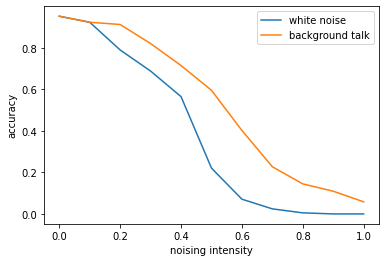

In [41]:
#@markdown Průměrná přesnost pro jednotlivé intenzity zašumení
csv = "white_noise_comparison"
compare = pd.read_csv(f"USVP_2022/{csv}.csv")
print(csv)
white_noise = []
for i in range(len(intensities)):
  prumer = compare[f"acc for intensity {intensities[i]}"].mean()
  print(f"Průměrná přesnost pro intenzitu zašumění {intensities[i]} je {prumer}")
  white_noise.append(prumer)

csv = "background_talk_comparison"
compare = pd.read_csv(f"USVP_2022/{csv}.csv")
print(csv)
background_talk = []
for i in range(len(intensities)):
  prumer = compare[f"acc for intensity {intensities[i]}"].mean()
  print(f"Průměrná přesnost pro intenzitu zašumění {intensities[i]} je {prumer}")
  background_talk.append(prumer)

plt.plot(intensities,white_noise)
plt.plot(intensities,background_talk)
plt.legend(["white noise", "background talk"])
plt.xlabel("noising intensity")
plt.ylabel("accuracy")
plt.show()

In [30]:
#@markdown # Testing and comparing speech recognition with audio noising
#intensities = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#@markdown (**není nutné spouštět...vyexportovaná data jsou v předchozích buňkách**)

compare = pd.DataFrame()
compare["sentences"] = cont_lines_modded
compare["number of words"] = [len(cont_lines_modded[i].split()) for i in range(len(cont_lines_modded))]
#@markdown Choose noising type for testing
#@markdown ___

#@markdown 0 - white noise addition

#@markdown 1 - background talk addition
noising_type = 0 #@param ["0", "1"] {type:"raw"}

for i, inten in enumerate(intensities):
  print(f"Intensity {inten}")
  rec = []
  acc = []
  SNR = [] #signal to noise ratio
  N = 0
  S = 0
  D = 0
  I = 0
  for j in range(len(cont_lines_modded)):
    sys.stdout.write(f"\rProcessing sentence {j}/{len(cont_lines_modded)-1}")
    sys.stdout.flush()

    #text to speech bez znamenek
    synthesize(f"ukol_02_radek_{j:02}.wav", cont_lines_modded[j], "Alena210", "wav")

    #noising
    numpy_wavfile, sample_rate = librosa.load(f"ukol_02_radek_{j:02}.wav")
    noised_wavfile, snr = noise(numpy_wavfile,out_fn=noising_type, intensity=inten, sr=sample_rate)
    noised_wavfile = noised_wavfile.astype(np.float32)
    wavfile.write(f"ukol_02_radek_{j:02}_noised_{(inten*100):03}.wav",rate=sample_rate, data=noised_wavfile)

    #recognition
    rec.append(" ".join(recognize(f"ukol_02_radek_{j:02}_noised_{(inten*100):03}.wav", "CLARIN_ASR/CZ", words_only=True)))
    
    #evaluation
    e = calc_edit_ops(cont_lines_modded[j].split(),rec[j].lower().split())
    N+=e.N
    S+=e.S
    D+=e.D
    I+=e.I
    accuracy = (e.N-e.S-e.D-e.I)/e.N
    acc.append(accuracy)
    SNR.append(snr)
  print("")
  compare[f"acc for intensity {inten}"] = acc
  compare[f"SNR for intensity {inten}"] = SNR

compare



Intensity 0
Processing sentence 9/9
Intensity 0.1
Processing sentence 9/9
Intensity 0.2
Processing sentence 9/9
Intensity 0.3
Processing sentence 9/9
Intensity 0.4
Processing sentence 9/9
Intensity 0.5
Processing sentence 9/9
Intensity 0.6
Processing sentence 9/9
Intensity 0.7
Processing sentence 9/9
Intensity 0.8
Processing sentence 9/9
Intensity 0.9
Processing sentence 9/9
Intensity 1.0
Processing sentence 9/9


sentences  number of words  \
0  o půlnoci odešla velká británie z evropské uni...               33   
1                 to jsou mnohokrát opakovaná fakta                 5   
2   vina je na junckerově vedení unie které nebyl...               59   
3                                      co bude dál                  3   
4   to nikdo neví půlnoční odchod neznamená nic j...               28   
5   napříště budeme ušetřeni trapných - televizí ...               24   
6   vedení unie nepochybně selhalo a otevřelo spo...               20   
7                     nicméně ani to není podstatné                 5   
8          je třeba se na situaci dívat realisticky                 7   
9   i v této turbulentní době se ozývají hlasy pr...               30   

   acc for intensity 0 SNR for intensity 0  acc for intensity 0.1  \
0             0.939394                None               0.878788   
1             1.000000                None               1.000000   
2             1.000000                None               0.966102   
3             0.666667                None               0.666667   
4             1.000000                None               0.964286   
5             0.916667                None               0.791667   
6             1.000000                None               1.000000   
7             1.000000                None               1.000000   
8             1.000000                None               1.000000   
9             1.000000                None               1.000000   

   SNR for intensity 0.1  acc for intensity 0.2  SNR for intensity 0.2  \
0              25.189578               0.848485              11.268901   
1              22.743300               0.800000              10.867211   
2              25.088232               0.864407              12.169478   
3              19.738581               0.333333               6.250903   
4              23.135057               0.928571              12.318415   
5              23.955046               0.666667              10.824242   
6              24.810387               1.000000              11.379765   
7              17.472729               1.000000               6.254855   
8              20.802404               1.000000               7.625804   
9              25.896515               0.900000              12.307222   

   acc for intensity 0.3  SNR for intensity 0.3  ...  acc for intensity 0.6  \
0               0.696970               4.617293  ...               0.242424   
1               0.400000               3.177235  ...               0.000000   
2               0.762712               7.098836  ...               0.220339   
3               0.333333              -0.398029  ...               0.000000   
4               0.714286               4.975524  ...               0.000000   
5               0.625000               4.811997  ...               0.083333   
6               0.500000               3.989586  ...               0.000000   
7               1.000000              -1.591691  ...               0.000000   
8               1.000000               2.047783  ...               0.142857   
9               0.766667               5.896747  ...               0.100000   

   SNR for intensity 0.6  acc for intensity 0.7  SNR for intensity 0.7  \
0              -5.335689               0.030303              -8.349493   
1              -8.551998               0.000000              -7.868184   
2              -5.447914               0.050847              -8.033558   
3             -11.541338               0.000000             -13.002173   
4              -7.931355               0.000000             -11.796690   
5              -8.290554               0.000000             -11.394880   
6              -7.560203               0.050000             -10.766784   
7             -13.197636               0.000000             -14.549425   
8             -10.025883               0.000000             -14.273338   
9              -6.998378               0.066667       

## Úkol 3

> Bez použití šumu je přesnost rozpoznávání menší než 100% z důvodu nahrazování běžně používaných zkratek v originálním textu, které rozpoznávač nahradí plnou formou

> rozpoznávač špatně rozpoznává slova: homogenní, karpální, diškrece (dýško), žranice, kraken, zebra

> pochopitelnost rozpoznaného textu po zašumění je při obou typech šumu okolo přesnosti (accuracy) do **0.6** dále může být až někdy do 0.5, ale vyjímečně a za domýšlení více slov podle kontextu

In [42]:
#@markdown # Ověření, jak rozpoznávač rozpoznává slova
#@markdown ---
slovo = "\"homogenn\xED" #@param {type:"string"}
synthesize("test.wav", slovo.split(), "Alena210", "wav44kHz16bit")
rec = recognize("test.wav", "CLARIN_ASR/CZ", words_only=True)
print(rec)
Audio("test.wav")

['O', 'homogenní']


In [67]:
#@title {run:"auto"}
#@markdown #Poslech srozumitelnsti vět
#@markdown ---
veta = 0 #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] {type:"raw"}
typ_sumu = 1 #@param ["0", "1"] {type:"raw"}
zasumeni = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}


print(f"PUVODNI INFORMACE\n{cont_lines_modded[veta]}")
zvuk = f"USVP_2022/sum_{typ_sumu+1}_gen_audio/ukol_02_radek_{veta:02}_noised_{(zasumeni*100):03}.wav"
rozp = recognize(zvuk, "CLARIN_ASR/CZ", words_only=True)
print(f"ROZPOZNANA INFORMACE")
print(" ".join(rozp))
Audio(zvuk)


PUVODNI INFORMACE
o půlnoci odešla velká británie z evropské unie stalo se tak následkem referenda ve kterém byl výsledek v mezích statistické chyby následek  rozdělený národ hrozba rozpadu země posíleny odstředivé proudy nejistá budoucnost nejistota 
ROZPOZNANA INFORMACE
Velká Británie město muset Praze dva ve premiér kdyby byl rozdělený na dvě stě padesát devět pro byznys budoucnosti
